# Transfer learning de un modelo preentrenado con Imagenet-1k entrenado con el dataset CIFAR-10

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import math

## Conjuntos de datos

Files already downloaded and verified
Dimensiones de las imagenes - altura: 32, anchura: 32, canales: 3
Files already downloaded and verified
Files already downloaded and verified


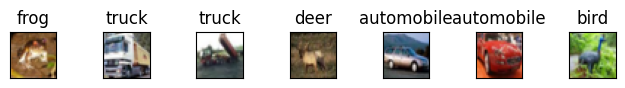

In [2]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
fig = plt.figure()
label_names = train_set.classes
for i, (data, label) in enumerate(train_set):
  data = data.permute(1, 2, 0)
  h, w, c = data.shape
  if i == 0:
    print(f"Dimensiones de las imagenes - altura: {h}, anchura: {w}, canales: {c}")
  plt.subplot(1,7,i+1)
  fig.tight_layout()
  plt.title(label_names[label])
  plt.imshow(data)
  plt.xticks([])
  plt.yticks([])
  if i > 5:
    break
      
# Normalizar
train_set = torch.stack([img for img, _ in train_set], dim=0)
mean = train_set.mean()
std = train_set.std()

batch_size = 16 # Tamaño de los lotes de muestras
# Preprocesado de las muestras
transform_and_resize = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=mean, std=std),
            torchvision.transforms.Resize((224,224))
                                           ])

# Carga el dataset de entrenamiento y validación ya normalizado
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_and_resize)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_and_resize)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

## Modelo

In [3]:
# Utilizamos un modelo prediseñado de TorchVision
model = torchvision.models.alexnet(weights = "AlexNet_Weights.IMAGENET1K_V1")
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
# Congelamos los pesos del modelo
for param in model.parameters():
    param.requires_grad = False
    
# Lo adaptamos a nuestro dataset
model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
for param in model.classifier[6].parameters():
    param.requires_grad = True
print(model)
print(f"¿La primera capa es entrenable? {model.features[0].weight.requires_grad}")
print(f"¿La última capa es entrenable? {model.classifier[6].weight.requires_grad}")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
n_epochs = 5

criterion = nn.CrossEntropyLoss()  # Función de pérdida
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Almacenamos métricas
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

print("Empezamos el entrenamiento...")
for epoch in range(n_epochs): 
    # Métricas
    running_loss, correctas, total = 0.0, 0, 0
    
    model.train()
    for data, target in train_loader:        
        optimizer.zero_grad() # Reinicia el optimizador
        output = model(data) # Forward-Pass
        loss = criterion(output, target)
        loss.backward() # Backward-Pass
        optimizer.step() # Actualiza los pesos

        # Métricas
        running_loss += loss.item()
        _, prediccion = output.max(1)
        total += target.size(0)
        correctas += prediccion.eq(target).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correctas / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validación del modelo
    # Métricas
    val_loss, correctas, total = 0.0, 0, 0
    
    model.eval()
    with torch.no_grad(): # No calculamos gradientes en validación
        for data, target in val_loader:
            output = model(data) # Forward-Pass
            loss = criterion(output, target)

            # Métricas
            val_loss += loss.item()
            _, prediccion = output.max(1)
            total += target.size(0)
            correctas += prediccion.eq(target).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100. * correctas / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Imprimimos las métricas por época
    print(f"Epoch [{epoch + 1}/{n_epochs}]", end=" | ")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%", end=" | ")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Empezamos el entrenamiento...
Epoch [1/5] | Train Loss: 0.9292, Train Accuracy: 70.46% | Val Loss: 0.6803, Val Accuracy: 77.45%
Epoch [2/5] | Train Loss: 0.8169, Train Accuracy: 74.42% | Val Loss: 0.6645, Val Accuracy: 78.60%
Epoch [3/5] | Train Loss: 0.7978, Train Accuracy: 75.31% | Val Loss: 0.6370, Val Accuracy: 79.65%
Epoch [4/5] | Train Loss: 0.7894, Train Accuracy: 75.83% | Val Loss: 0.6356, Val Accuracy: 79.61%
Epoch [5/5] | Train Loss: 0.7754, Train Accuracy: 76.09% | Val Loss: 0.6721, Val Accuracy: 78.65%


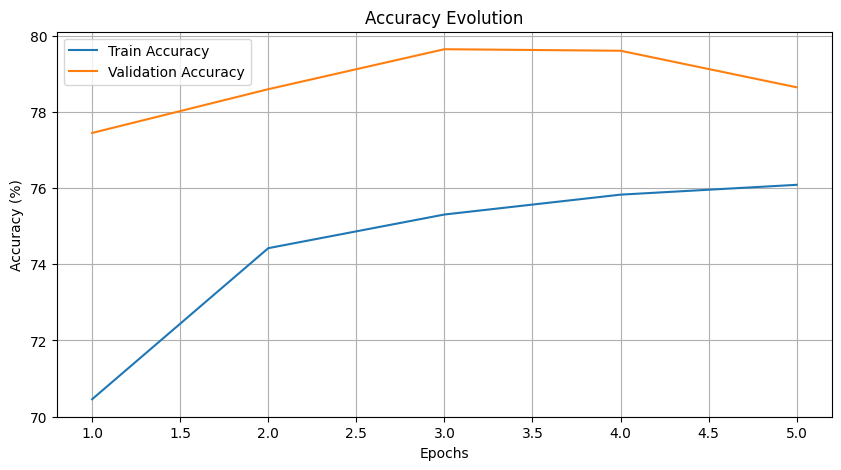

In [7]:
# Representamos la evolución del accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Evolution')
plt.legend()
plt.grid()
plt.show()

## Guardar y cargar un modelo entrenado

In [11]:
def save_model(model, optimizer, path='./model.pth'):
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(state, path)
    print(f"Model saved to {path}")

def load_model(model, optimizer, path='./model.pth'):
    checkpoint = torch.load(path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model loaded from {path}")

In [12]:
save_model(model, optimizer, path="./alexnet.pth")

Model saved to ./alexnet.pth


In [13]:
load_model(model, optimizer, path="./alexnet.pth")

Model loaded from ./alexnet.pth
